<a target="_blank" href="https://colab.research.google.com/github/heechul/DeepPicar-v3/blob/devel/RunAll.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>

In [41]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import read_csv
from sklearn.model_selection import train_test_split
import math
# from skimage import data
from skimage import io
from skimage.exposure import match_histograms

In [42]:
# input image resolution to the DNN model (smaller than the original dataset image resolution: 320x240x3)
img_width = 200
img_height = 66
img_channels = 3

model_name = "model_large"
model_file = "models/{}-{}x{}x{}".format(model_name[6:], img_width, img_height, img_channels)

In [43]:
import requests 
import os
import zipfile

dataset_dir = "dataset"
dataset_zipfile = 'Dataset.zip'
RunningInCOLAB = 'google.colab' in str(get_ipython())
force_unzip = False
use_match_histogram = False

if RunningInCOLAB: 
    print("in colab")
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
        dataset_zipfile = fn  # expecting a zip file to be uploaded. 
else:
    print ("not in colab")
    # RPI_IP=None # replace this with the IP address of your raspberry pi 
    # if RPI_IP is not None:
    #     URL="http://"+RPI_IP+":8000/"+dataset_zipfile
    #     filename=URL.split('/')[-1]
    #     r = requests.get(URL)
    #     open(filename, 'wb').write(r.content)

if not os.path.isfile(dataset_zipfile):
    default_dataset_URL = "https://raw.githubusercontent.com/heechul/DeepPicar-v3/devel/Dataset-kucsl-Apr2022.zip"    
    print ("No existing dataset. download from ", default_dataset_URL)
    r = requests.get(default_dataset_URL)
    open(dataset_zipfile, 'wb').write(r.content)

if not os.path.isdir(dataset_dir) or force_unzip==True:
    print ('unzip %s into %s folder' % (dataset_zipfile, dataset_dir))
    zip_ref = zipfile.ZipFile(dataset_zipfile)
    zip_ref.extractall(dataset_dir)

not in colab


In [44]:
if use_match_histogram:
    refs = []
    num_spectrums = 5
    size = img_width*img_height
    num_colors = int(256 / num_spectrums)
    color_pixels = int(size / num_colors)
    color = 0
    for s in range(num_spectrums): 
        num_color = 0
        img = []
        for i in range(img_height):
            img.append([])
            for j in range(img_width):
                img[i].append([])
                #for k in range(3):
                img[i][j].append(color)
                img[i][j].append(color)
                img[i][j].append(color)
                num_color += 1
                if num_color == color_pixels - 1:
                    if not color == 255:
                        color += 1
                    num_color = 0            
        img = np.asarray(img, dtype=np.uint8) / 255.
        refs.append(img)

In [45]:
# Train/test data lists
imgs = []
vals = []

def crop_image(img):
  scaled_img = cv2.resize(img, (max(int(img_height * 4 / 3), img_width), img_height))
  fb_h, fb_w, fb_c = scaled_img.shape
  # print(scaled_img.shape)
  startx = int((fb_w - img_width) / 2);
  starty = int((fb_h - img_height) / 2);
  return scaled_img[starty:starty+img_height, startx:startx+img_width,:]

print ("scaled input image size: ", int(img_height * 4 / 3), img_height)

import glob
for vid_file_path in glob.iglob(f'{dataset_dir}/*.avi'):
    csv_file_path = vid_file_path.replace('video', 'key').replace('avi', 'csv')
    print(vid_file_path, csv_file_path)
    vid = cv2.VideoCapture(vid_file_path)
    df = read_csv(csv_file_path)
    for val in df["wheel"].values:
        ret,img = vid.read()
        img = crop_image(img)
        # print(img.shape)
        # img = cv2.resize(img, (img_width, img_height))
        # Convert to grayscale and readd channel dimension
        if img_channels == 1:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = np.reshape(img, (img_height, img_width, img_channels))
        img = img / 255.
        imgs.append(img)
        vals.append(val)
        if use_match_histogram == True:
            for i in range(num_spectrums):
                matched = match_histograms(img, refs[i], multichannel=True) # channel_axis=-1
                imgs.append(matched)
                vals.append(val)
    print(len(imgs), len(vals))

# Convert lists to numpy arrays and ensure they are of equal length    
imgs = np.asarray(imgs)  # input images
vals = np.asarray(vals)  # steering angles
assert len(imgs) == len(vals)
print("Loaded {} smaples".format(len(imgs)))

dataset/out-video-0605.avi dataset/out-key-0605.csv
1000 1000
dataset/out-video-0605-r.avi dataset/out-key-0605-r.csv
2000 2000
Loaded 2000 smaples


In [46]:
if use_match_histogram:
    fig, axises = plt.subplots(nrows=1, ncols=num_spectrums+1, figsize=(8, 4),
                                        sharex=True, sharey=True)
    for i in range(num_spectrums+1):
        aa = axises[i]
        aa.imshow(imgs[240 + i])
    plt.tight_layout()
    plt.show()

In [47]:
# Split the dataset for train and test 
print("Train/Test")
x_train, x_test, y_train, y_test = train_test_split(imgs, vals, test_size=0.25)

Train/Test


In [48]:
from keras import layers

use_depthmodel = False
if use_depthmodel == True: 
  # depthwise convolution model (doesn't work for some reason!!!)
  model = tf.keras.Sequential()
  model.add(layers.DepthwiseConv2D((5,5), strides=(2,2), activation='relu', input_shape=(img_height,img_width,img_channels)))
  model.add(layers.Conv2D(24, (1,1), strides=(1,1), activation='relu'))

  model.add(layers.DepthwiseConv2D((5,5), strides=(2,2), activation='relu'))
  model.add(layers.Conv2D(36, (1,1), strides=(1,1), activation='relu'))

  model.add(layers.DepthwiseConv2D((5,5), strides=(2,2), activation='relu'))
  model.add(layers.Conv2D(48, (1,1), strides=(1,1), activation='relu'))

  model.add(layers.DepthwiseConv2D((3,3), activation='relu'))
  model.add(layers.Conv2D(64, (1,1), activation='relu'))

  model.add(layers.DepthwiseConv2D((3,3), activation='relu'))
  model.add(layers.Conv2D(64, (1,1), activation='relu'))

  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dense(50, activation='relu'))
  model.add(layers.Dense(10, activation='relu'))
  model.add(layers.Dense(1, activation='tanh'))

else:
  # original model
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(img_height,img_width,img_channels)))
  model.add(layers.Conv2D(36, (5,5), strides=(2,2), activation='relu'))
  model.add(layers.Conv2D(48, (5,5), strides=(2,2), activation='relu'))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dense(50, activation='relu'))
  model.add(layers.Dense(10, activation='relu'))
  model.add(layers.Dense(1, activation='tanh'))

In [49]:
#print(x_train[0])
print ("Model compile")
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                loss='mse')
model.summary()

Model compile
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_12 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0         
                                                                 
 dense_8 (Dense)             (None, 100)

Model fit
Epoch 1/10
15/15 [==============================] - 2s 123ms/step - loss: 0.0654 - val_loss: 0.0604
Epoch 2/10
15/15 [==============================] - 2s 121ms/step - loss: 0.0516 - val_loss: 0.0431
Epoch 3/10
15/15 [==============================] - 2s 121ms/step - loss: 0.0407 - val_loss: 0.0374
Epoch 4/10
15/15 [==============================] - 2s 115ms/step - loss: 0.0363 - val_loss: 0.0343
Epoch 5/10
15/15 [==============================] - 2s 112ms/step - loss: 0.0347 - val_loss: 0.0339
Epoch 6/10
15/15 [==============================] - 2s 111ms/step - loss: 0.0337 - val_loss: 0.0315
Epoch 7/10
15/15 [==============================] - 2s 115ms/step - loss: 0.0320 - val_loss: 0.0321
Epoch 8/10
15/15 [==============================] - 2s 121ms/step - loss: 0.0316 - val_loss: 0.0302
Epoch 9/10
15/15 [==============================] - 2s 149ms/step - loss: 0.0304 - val_loss: 0.0293
Epoch 10/10
15/15 [==============================] - 2s 121ms/step - loss: 0.0301 - val_lo

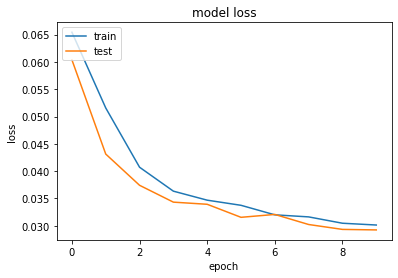

In [50]:
print ("Model fit")
model.reset_states()
history = model.fit(x_train, y_train, batch_size=100,
                    epochs=10, validation_data=(x_test, y_test))

# Plot training and validation losses 
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
# Helper functions for evaluating model accuracy
def rad2deg(rad):
  return 180.0 * rad / math.pi
def get_action(angle_rad):
  degree = rad2deg(angle_rad)
  if degree < 15 and degree > -15:
    return "center"
  elif degree >= 15:
    return "right" 
  elif degree <-15:
    return "left"

In [52]:
pred_angle = model.predict(x_test)
pred = np.array(list(map(get_action, pred_angle)))
ground = np.array(list(map(get_action, y_test)))
print('Accuracy is %.3f' % np.mean(pred == ground))

Accuracy is 0.858


visualization

In [53]:
def plot_image(i, prediction_array, groundtrue_array, img_array):
  angle, predicted_label, groundtrue_label, img = int(rad2deg(pred_angle[i])), prediction_array[i], groundtrue_array[i], img_array[i]
  plt.grid(True)
  plt.xticks([])
  plt.yticks([])
  img = np.squeeze(img)
  plt.imshow(img, cmap=plt.cm.binary)
  if predicted_label == groundtrue_label:
    color = 'green'
  else:
    color = 'red'  
  plt.xlabel("Predict:{} ({}) Actual:{}".format(predicted_label,angle,groundtrue_label), color=color)

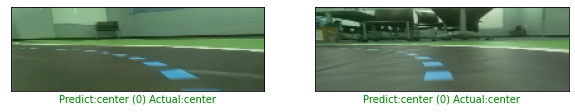

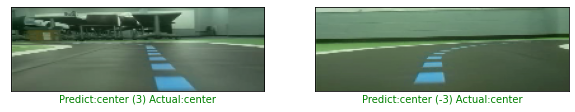

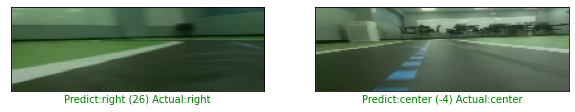

In [54]:
#@title Visualize the outputs { run: "auto" }
index = 0 #@param {type:"slider", min:0, max:244, step:6}
for i in range(3):
  plt.figure(figsize=(10,3))
  plt.subplot(1,2,1)
  plot_image(index + 2*i, pred, ground, x_test)
  plt.subplot(1,2,2)
  plot_image(index + 2*i+1, pred, ground, x_test)
  plt.show()

In [55]:
# Save both the Keras and TFLite models      
print("Model Save")                  
model.save(model_file+".h5")

print("TFLite Model")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]

quantized_tflite_model = converter.convert()

with open(model_file+".tflite", 'wb') as f:
    f.write(quantized_tflite_model)

print (model_file+".tflite is saved. copy this file to the robot")

if RunningInCOLAB: 
    from google.colab import files
    files.download(model_file+".tflite")

Model Save
TFLite Model
INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpmkfnvoil/assets


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpmkfnvoil/assets
2022-06-05 10:19:52.703236: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-06-05 10:19:52.703358: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-06-05 10:19:52.704748: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpmkfnvoil
2022-06-05 10:19:52.707477: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-06-05 10:19:52.707483: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpmkfnvoil
2022-06-05 10:19:52.712721: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-06-05 10:19:52.761028: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

models/large-200x66x3.tflite is saved. copy this file to the robot
